# Imports

In [ ]:
!pip install keras
!pip install kaggle
!pip install tensorflow
!pip install python-docx
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
import re
import os
import docx
import torch
import zipfile
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
from google.colab import files
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.models import Model
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from tensorflow.keras import layers, Model, Input
from sklearn.ensemble import RandomForestRegressor
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tokenizers import models, trainers, pre_tokenizers, processors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Lambda, Subtract, Dropout


# Kaggle login and  extract data

In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-depot-product-search-relevance

Saving kaggle.json to kaggle.json
 99% 69.0M/69.4M [00:04<00:00, 21.4MB/s]
100% 69.4M/69.4M [00:04<00:00, 16.0MB/s]


#Extract data from unzip

In [ ]:
with zipfile.ZipFile("/content/home-depot-product-search-relevance.zip", "r") as zip_ref:
    zip_ref.extractall("home_depot")

with zipfile.ZipFile("/content/home_depot/attributes.csv.zip", "r") as zip_ref:
    zip_ref.extractall("attributes")
with zipfile.ZipFile("/content/home_depot/product_descriptions.csv.zip", "r") as zip_ref:
    zip_ref.extractall("product_descriptions")
with zipfile.ZipFile("/content/home_depot/sample_submission.csv.zip", "r") as zip_ref:
    zip_ref.extractall("sample_submission")
with zipfile.ZipFile("/content/home_depot/test.csv.zip", "r") as zip_ref:
    zip_ref.extractall("test")
with zipfile.ZipFile("/content/home_depot/train.csv.zip", "r") as zip_ref:
    zip_ref.extractall("train")

In [ ]:
attributes = pd.read_csv("/content/attributes/attributes.csv")
product_descriptions = pd.read_csv("/content/product_descriptions/product_descriptions.csv")
sample_submission = pd.read_csv("/content/sample_submission/sample_submission.csv")

train = pd.read_csv("/content/train/train.csv", encoding='latin1')
test = pd.read_csv("/content/test/test.csv", encoding='latin1')


#1

##a

function that Split text into single characters with space in between

In [ ]:
def text_to_char_sequence(text):
    return ' '.join(list(str(text)))


train['search_term_chars'] = train['search_term'].apply(text_to_char_sequence)
train['product_title_chars'] = train['product_title'].apply(text_to_char_sequence)

test['search_term_chars'] = test['search_term'].apply(text_to_char_sequence)
test['product_title_chars'] = test['product_title'].apply(text_to_char_sequence)

#b

# Text to sequence

In [ ]:
# Combine search terms and product descriptions for consistent tokenization
texts = train['search_term'].tolist() + train['product_title'].tolist()

# Character-level tokenization
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(texts)

# Convert text to sequences
train_search_seq = tokenizer.texts_to_sequences(train['search_term'])
train_title_seq = tokenizer.texts_to_sequences(train['product_title'])
test_search_seq = tokenizer.texts_to_sequences(test['search_term'])
test_title_seq = tokenizer.texts_to_sequences(test['product_title'])

# Padding sequences to a fixed length
max_seq_length = 293
train_search_seq = pad_sequences(train_search_seq, maxlen=max_seq_length, padding='post')
train_title_seq = pad_sequences(train_title_seq, maxlen=max_seq_length, padding='post')
test_search_seq = pad_sequences(test_search_seq, maxlen=max_seq_length, padding='post')
test_title_seq = pad_sequences(test_title_seq, maxlen=max_seq_length, padding='post')

# Siameses network

##CNN

In [ ]:
def create_hidden_layer(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x)

def distance_layer(inputs):
    x1, x2 = inputs
    return tf.reduce_sum(tf.square(x1 - x2), axis=1, keepdims=True)


# Define the subnetwork
def create_siamese_branch(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, 10, activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 7, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 4, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 4, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)
    return Model(inputs, x)

# Input shapes
input_shape = (max_seq_length,)

# Define inputs
input1 = Input(shape=input_shape, name="search_input")
input2 = Input(shape=input_shape, name="title_input")

# Shared subnetwork
shared_network = create_hidden_layer(input_shape)

# Process inputs through the subnetwork
output1 = shared_network(input1)
output2 = shared_network(input2)

# Compute the distance
distance = Lambda(distance_layer, name="distance_layer")([output1, output2])

# Output layer
output = Dense(1, activation='sigmoid', name="output_layer")(distance)

# Build the model
siamese_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse') ])

siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ search_input (InputLayer) │ (None, 293)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 293)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 32)             │         20,896 │ search_input[0][0],    │
│                           │                        │                │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_layer (Lambda)   │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │              2 │ distance_layer[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,898 (81.63 KB)

 Trainable params: 20,898 (81.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_search_seq = train_search_seq.reshape(train_search_seq.shape[0], train_search_seq.shape[1])
train_title_seq = train_title_seq.reshape(train_title_seq.shape[0], train_title_seq.shape[1])

test_search_seq = test_search_seq.reshape(test_search_seq.shape[0], test_search_seq.shape[1])
test_title_seq = test_title_seq.reshape(test_title_seq.shape[0], test_title_seq.shape[1])

# Define the target variable (relevance score)
train_labels = train['relevance'].values

# Prepare data
train_search_seq = train_search_seq.astype('float32')
train_title_seq = train_title_seq.astype('float32')

# Train the model
history_char =siamese_model.fit(
    [train_search_seq, train_title_seq],
    train_labels,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.5430 - mae: 1.5041 - rmse: 1.5946 - val_loss: 1.8850 - val_mae: 1.2706 - val_rmse: 1.3729
Epoch 2/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3814 - mae: 1.4487 - rmse: 1.5432 - val_loss: 1.8292 - val_mae: 1.2485 - val_rmse: 1.3525
Epoch 3/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3459 - mae: 1.4372 - rmse: 1.5316 - val_loss: 1.8066 - val_mae: 1.2394 - val_rmse: 1.3441
Epoch 4/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3070 - mae: 1.4239 - rmse: 1.5189 - val_loss: 1.7966 - val_mae: 1.2353 - val_rmse: 1.3404
Epoch 5/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2993 - mae: 1.4204 - rmse: 1.5163 - val_loss: 1.7920 - val_mae: 1.2335 - val_rmse: 1.3387
Epoch 6/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2984 - mae: 1.4217 - rmse: 1.5161 - val_loss: 1.7899 - val_mae: 1.2327 - val_rmse: 1.3379
Epoch 7/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3079 - mae: 

In [ ]:
predictions = siamese_model.predict([test_search_seq, test_title_seq])
predictions = pd.DataFrame(predictions)
predictions

solution = pd.read_csv("/content/solution.csv")

predictions['id'] = solution['id']
predictions.rename(columns={0: 'relevance'}, inplace=True)
predictions

# Merge the DataFrames on 'id'
merged_df = pd.merge(predictions, solution, on='id', suffixes=('_pred', '_true'))

# Filter out rows where the true relevance is -1
filtered_df = merged_df[merged_df['relevance_true'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['relevance_pred'].values
true_relevance = filtered_df['relevance_true'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")


# Predict on the test set
test_predictions = siamese_model.predict([test_search_seq, test_title_seq])

# Rescale predictions back to original relevance score range
test_predictions = test_predictions * train['relevance'].max()

print(test_predictions)



test_predictions = pd.DataFrame(test_predictions)

solution['prediction'] = test_predictions[0]

# Filter out rows where the true relevance is -1
filtered_df = solution[solution['relevance'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['prediction'].values
true_relevance = filtered_df['relevance'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")

5210/5210 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Root Mean Squared Error (RMSE): 1.4806635583365144
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
[[3.]
 [3.]
 [3.]
 ...
 [3.]
 [3.]
 [3.]]
Root Mean Squared Error (RMSE): 0.818697205695263


In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 8))

    # Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history.history['mae'], label='Train MAE', marker='o')
    plt.plot(epochs, history.history['val_mae'], label='Validation MAE', marker='o')
    plt.title('Mean Absolute Error (MAE) over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # RMSE (if available)
    if 'rmse' in history.history and 'val_rmse' in history.history:
        plt.subplot(3, 1, 3)
        plt.plot(epochs, history.history['rmse'], label='Train RMSE', marker='o')
        plt.plot(epochs, history.history['val_rmse'], label='Validation RMSE', marker='o')
        plt.title('Root Mean Squared Error (RMSE) over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# plot_training_history(history_char)


In [ ]:
for key, values in history_char.history.items():
    print(f"{key}: {values}")

loss: [2.4855847358703613, 2.3697896003723145, 2.327979326248169, 2.310234785079956, 2.3022871017456055, 2.298654794692993, 2.2969770431518555, 2.2962026596069336, 2.295839548110962, 2.2956767082214355, 2.295597791671753, 2.2955596446990967, 2.295546531677246, 2.2955398559570312, 2.2955322265625, 2.2955336570739746, 2.295532464981079, 2.2955322265625, 2.295532464981079, 2.295531749725342]
mae: [1.484370231628418, 1.4449888467788696, 1.4304425716400146, 1.4242364168167114, 1.4214421510696411, 1.4201629161834717, 1.4195716381072998, 1.419298768043518, 1.419171690940857, 1.4191081523895264, 1.4190922975540161, 1.4190813302993774, 1.419070839881897, 1.419067144393921, 1.419066309928894, 1.419066309928894, 1.4190658330917358, 1.4190664291381836, 1.419066071510315, 1.4190648794174194]
rmse: [1.5765737295150757, 1.5394121408462524, 1.5257717370986938, 1.5199456214904785, 1.5173289775848389, 1.5161315202713013, 1.5155781507492065, 1.5153225660324097, 1.5152027606964111, 1.5151491165161133, 1.5

##C

# Option 1

In [ ]:
# Vectorize the character-level sequences
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3))  # Character-level n-grams
search_term_vec = vectorizer.fit_transform(train['search_term_chars'])
product_title_vec = vectorizer.transform(train['product_title_chars'])

# Combine features
X_train = search_term_vec + product_title_vec  # Element-wise addition of sparse matrices
y_train = train['relevance']

# Train a simple benchmark model
model = LinearRegression()
model.fit(X_train, y_train)

# Apply the same transformations to the test data
search_term_vec_test = vectorizer.transform(test['search_term_chars'])
product_title_vec_test = vectorizer.transform(test['product_title_chars'])
X_test = search_term_vec_test + product_title_vec_test  # Combine test features

# Predict relevance scores for the test data
test['prediction'] = model.predict(X_test)

# Option 2

## Shared Network

In [ ]:
# Embedding dimension
embedding_dim = 50

# Define the shared embedding + convolutional network
def shared_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)(inputs)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inputs, x)

# Input layers for search term and product description
input_shape = (max_seq_length,)
search_input = Input(shape=input_shape, name="search_input")
title_input = Input(shape=input_shape, name="title_input")

# Shared network
shared_net = shared_network(input_shape)

# Process both inputs through the shared network
search_embedding = shared_net(search_input)
title_embedding = shared_net(title_input)

# Compute the absolute difference between embeddings
distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([search_embedding, title_embedding])

# Add a dense layer and output layer
x = Dense(32, activation='relu')(distance)
output = Dense(1, activation='sigmoid', name="output_layer")(x)

# Build the Siamese model
siamese_model = Model(inputs=[search_input, title_input], outputs=output)

# Compile the model
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse') ])

siamese_model.summary()


# Convert relevance scores to a suitable range (0-1) if necessary
train['relevance_normalized'] = train['relevance'] / train['relevance'].max()

# Train the model
history=siamese_model.fit(
    [train_search_seq, train_title_seq],
    train['relevance_normalized'],
    batch_size=32,
    epochs=20,
    validation_split=0.2
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ search_input (InputLayer) │ (None, 293)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 293)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 64)             │         31,334 │ search_input[0][0],    │
│                           │                        │                │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 64)             │              0 │ functional_4[0][0],    │
│                           │                        │                │ functional_4[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          2,080 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │             33 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,447 (130.65 KB)

 Trainable params: 33,447 (130.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0373 - mae: 0.1570 - rmse: 0.1918 - val_loss: 0.0351 - val_mae: 0.1479 - val_rmse: 0.1874
Epoch 2/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0293 - mae: 0.1402 - rmse: 0.1712 - val_loss: 0.0330 - val_mae: 0.1439 - val_rmse: 0.1818
Epoch 3/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0273 - mae: 0.1349 - rmse: 0.1654 - val_loss: 0.0329 - val_mae: 0.1436 - val_rmse: 0.1813
Epoch 4/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0267 - mae: 0.1334 - rmse: 0.1635 - val_loss: 0.0315 - val_mae: 0.1411 - val_rmse: 0.1774
Epoch 5/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0255 - mae: 0.1298 - rmse: 0.1595 - val_loss: 0.0312 - val_mae: 0.1403 - val_rmse: 0.1766
Epoch 6/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0244 - mae: 0.1268 - rmse: 0.1563 - val_loss: 0.0306 - val_mae: 0.1396 - val_rmse: 0.1750
Epoch 7/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0239 - mae:

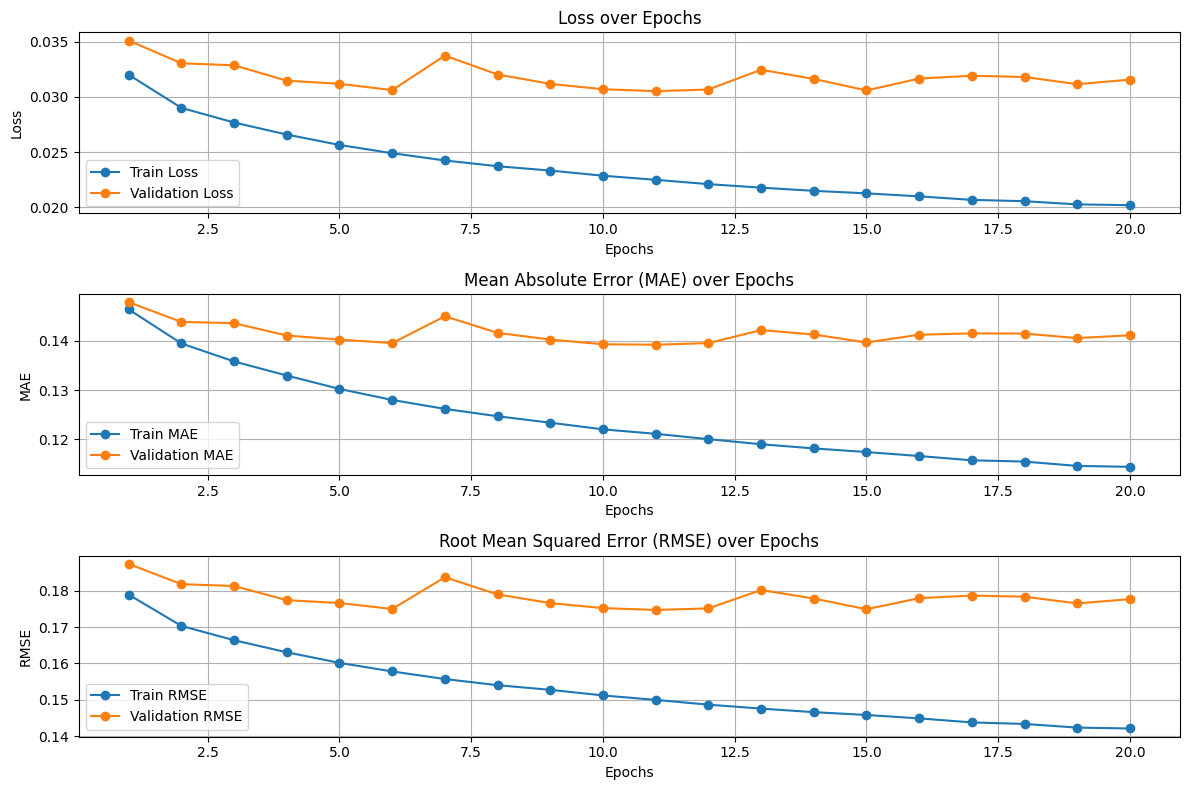

In [ ]:
plot_training_history(history)

In [ ]:
# Filter out rows with relevance = -1 from the solution
solution_filtered = solution[solution['relevance'] != -1]

# Ensure the test DataFrame is aligned with the solution
aligned_df = solution_filtered.copy()  # Copy solution_filtered
aligned_df['prediction'] = test['prediction'][:len(solution_filtered)].values  # Align predictions

# Calculate RMSE

rmse = np.sqrt(mean_squared_error(aligned_df['relevance'], aligned_df['prediction']))
print(f"Benchmark RMSE: {rmse}")

Benchmark RMSE: 0.5541332649421421


#Feature Extractor

In [ ]:
# Create a feature extractor model
feature_extractor = tf.keras.Model(inputs=shared_net.input, outputs=shared_net.output)

# Extract features for search and title inputs
train_search_features = feature_extractor.predict(train_search_seq)
train_title_features = feature_extractor.predict(train_title_seq)
test_search_features = feature_extractor.predict(test_search_seq)
test_title_features = feature_extractor.predict(test_title_seq)

# Combine features for search and title
train_features = np.concatenate([train_search_features, train_title_features], axis=1)
test_features = np.concatenate([test_search_features, test_title_features], axis=1)

# Print shapes to verify
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Train features shape: (74067, 128)
Test features shape: (166693, 128)


# Model 1 Linear Regression

In [ ]:
print(f"Shape of test_predictions: {test_predictions.shape}")
print(f"Shape of test_search_seq: {test_search_seq.shape}")
print(f"Shape of test_labels: {test_labels.shape}")
filtered_solution = solution[solution['relevance'] != -1]
print(f"Filtered solution length: {filtered_solution.shape[0]}")

Shape of test_predictions: (166693,)
Shape of test_search_seq: (166693, 293)
Shape of test_labels: (112067,)
Filtered solution length: 112067


In [ ]:
# Step 1: Handle -1 values in the solution
solution['relevance'] = solution['relevance'].apply(lambda x: 1 if x == -1 else x)

# Step 2: Extract true relevance (labels) for the test set
test_labels = solution['relevance'].values

# Step 3: Prepare the features and labels
# Ensure test_predictions aligns with solution's index
test_predictions = test_predictions[:len(test_labels)]

# Step 4: Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(train_features, train_labels)

# Step 5: Make predictions on train and test sets
train_predictions = lr_model.predict(train_features)
test_predictions = lr_model.predict(test_features)

# Step 6: Calculate metrics
train_rmse = np.sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)

# Step 7: Print results
print(f"Linear Regression - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Linear Regression - Train MAE: {train_mae}, Test MAE: {test_mae}")


Linear Regression - Train RMSE: 0.49624541105279596, Test RMSE: 0.9372246343636806
Linear Regression - Train MAE: 0.40341839339690094, Test MAE: 0.7607055455732551


# Model 2 Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

train_predictions = rf_model.predict(train_features)
test_predictions = rf_model.predict(test_features)

train_rmse = mean_squared_error(train_labels, train_predictions)
test_rmse = mean_squared_error(test_labels, test_predictions)
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)

print(f"Random Forest - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Random Forest - Train MAE: {train_mae}, Test MAE: {test_mae}")


Random Forest - Train RMSE: 0.029659988600545195, Test RMSE: 0.882615618889827
Random Forest - Train MAE: 0.1371500778159721, Test MAE: 0.7576775847119652


#2

##a

### Tokanize

In [ ]:
train_text = train['search_term'] + ' ' + train['product_title']
test_text = test['search_term'] + ' ' + test['product_title']

# # function for cleaning and normalizing text
def clean_and_tokenize_text(text):
    """
    Clean and tokenize text into words and special character combinations.
    Supports complex tokens like '12-Gauge', '¾', or '90°'.

    :param text: Input string.
    :return: List of cleaned and tokenized tokens.
    """
    # Step 1: Clean the text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces

    # Step 2: Define regex pattern for tokens
    token_pattern = r"""
        \b\d+-\w+\b      |  # Matches numbers followed by a dash and a word (e.g., 12-Gauge)
        \b\w+-\w+\b      |  # Matches words connected by a dash (e.g., Strong-Tie)
        \b\d+\u00b0\b    |  # Matches numbers followed by ° (e.g., 90°)
        \b\d+/\d+\b      |  # Matches fractions (e.g., 3/4)
        \b\w+[#\w]*\b    |  # Matches words with optional '#' or other alphanumeric characters
        [^\s\w]+            # Matches standalone special characters
    """

    # Step 3: Compile the regex with verbose flag for readability
    regex = re.compile(token_pattern, re.VERBOSE)

    # Step 4: Find all matches
    tokens = regex.findall(text)

    return tokens

# Combine and clean text for training and testing
train_text = train['search_term'] + ' ' + train['product_title']
test_text = test['search_term'] + ' ' + test['product_title']

# Tokenize and clean data
train_tokens = train_text.apply(lambda x: clean_and_tokenize_text(x) if isinstance(x, str) else [])
test_tokens = test_text.apply(lambda x: clean_and_tokenize_text(x) if isinstance(x, str) else [])

# Combine train and test data for tokenizer training
combined_tokens = [' '.join(tokens) for tokens in train_tokens if isinstance(tokens, list)] + \
                  [' '.join(tokens) for tokens in test_tokens if isinstance(tokens, list)]

# Initialize a Byte-Pair Encoding tokenizer
tokenizer = Tokenizer(models.BPE())
trainer = trainers.BpeTrainer(special_tokens=["<unk>"])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Train the tokenizer
tokenizer.train_from_iterator(combined_tokens, trainer)

# Encode data using the trained tokenizer
train['tokens'] = train_text.apply(lambda x: tokenizer.encode(x).tokens if isinstance(x, str) else [])
test['tokens'] = test_text.apply(lambda x: tokenizer.encode(x).tokens if isinstance(x, str) else [])

# Output to verify
print(train[['search_term', 'product_title', 'tokens']].head())
print(test[['search_term', 'product_title', 'tokens']].head())

          search_term                                      product_title  \
0       angle bracket                  Simpson Strong-Tie 12-Gauge Angle   
1           l bracket                  Simpson Strong-Tie 12-Gauge Angle   
2           deck over  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3    rain shower head  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  shower only faucet  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

                                              tokens  
0  [angle, bracket, im, pson, t, rong, -, ie, 12,...  
1  [l, bracket, im, pson, t, rong, -, ie, 12, -, ...  
2  [deck, over, re, mium, ex, tured, eck, ver, 1,...  
3  [rain, shower, head, el, ta, ero, 1, -, and, l...  
4  [shower, only, faucet, el, ta, ero, 1, -, and,...  
                 search_term                      product_title  \
0          90 degree bracket  Simpson Strong-Tie 12-Gauge Angle   
1           metal l brackets  Simpson Strong-Tie 12-Gauge Angle   
2           

###Because of computing power we chose to go for a fixed length of 50

In [ ]:
# Tokenize and pad the search_term column
input_length= 50
train['padded_search'] = train['search_term'].apply(
    lambda x: tokenizer.encode(x).ids[:input_length] + [0] * (input_length - len(tokenizer.encode(x).ids))
)

# Tokenize and pad the product_title column
train['padded_title'] = train['product_title'].apply(
    lambda x: tokenizer.encode(x).ids[:input_length] + [0] * (input_length - len(tokenizer.encode(x).ids))
)
train['relevance_normalized'] = train['relevance'] / train['relevance'].max()


In [ ]:
test['padded_search'] = test['search_term'].apply(
    lambda x: tokenizer.encode(x).ids[:input_length] + [0] * (input_length - len(tokenizer.encode(x).ids))
)

# Tokenize and pad the product_title column
test['padded_title'] = test['product_title'].apply(
    lambda x: tokenizer.encode(x).ids[:input_length] + [0] * (input_length - len(tokenizer.encode(x).ids))
)

#b.

#word2vec

In [ ]:
# Combine tokenized sentences from train and test datasets
tokenized_sentences = train['tokens'].tolist() + test['tokens'].tolist()

# Ensure all entries are lists of strings
tokenized_sentences = [tokens for tokens in tokenized_sentences if isinstance(tokens, list)]

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,  # Input sentences
    vector_size=100,                # Dimensionality of word vectors
    window=5,                       # Context window size
    min_count=2,                    # Minimum frequency for words
    workers=4,                      # Number of threads for training
    sg=1                            # Skip-gram model
)

# Save the Word2Vec model
word2vec_model.save("word2vec_model.model")

# Access the embedding of a specific word (example: "90°")
if "90°" in word2vec_model.wv:
    embedding_90_deg = word2vec_model.wv["90°"]
    print("Embedding for '90°':", embedding_90_deg)

# Check vocabulary size
print(f"Vocabulary size: {len(word2vec_model.wv.index_to_key)}")

# Save word embeddings as a dictionary for further use
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}


Vocabulary size: 16053


#C

## LSTM Siamese Network

In [ ]:
# Define input shapes
input_length = 50  # Example length of input sequences
embedding_dim = 100  # Word2Vec embedding dimension
lstm_units = 64  # Number of LSTM units

# Define input layers
search_input = Input(shape=(input_length,), name="search_input")
title_input = Input(shape=(input_length,), name="title_input")

# Shared Embedding layer (Word2Vec embedding)
embedding_layer = Embedding(input_dim=16053,  # Vocabulary size (example)
                            output_dim=embedding_dim,
                            input_length=input_length,
                            name="word2vec_embedding")

search_embedding = embedding_layer(search_input)
title_embedding = embedding_layer(title_input)

# Shared LSTM layer
shared_lstm = LSTM(lstm_units, name="shared_lstm")

search_lstm = shared_lstm(search_embedding)
title_lstm = shared_lstm(title_embedding)

# Dropout layers
search_dropout = Dropout(0.2, name="dropout")(search_lstm)
title_dropout = Dropout(0.2, name="dropout_1")(title_lstm)

# Lambda layer for absolute difference
l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name="lambda_1")([search_dropout, title_dropout])

# Output layer
output = Dense(1, activation="sigmoid", name="output_layer")(l1_distance)

# Build the model
siamese_model = Model(inputs=[search_input, title_input], outputs=output)

# Compile the model
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse') ])

# Model summary
siamese_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ search_input (InputLayer) │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word2vec_embedding        │ (None, 50, 100)        │      1,605,300 │ search_input[0][0],    │
│ (Embedding)               │                        │                │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_lstm (LSTM)        │ (None, 64)             │         42,240 │ word2vec_embedding[0]… │
│                           │                        │                │ word2vec_embedding[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ shared_lstm[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ shared_lstm[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 64)             │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │             65 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,647,605 (6.29 MB)

 Trainable params: 1,647,605 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train['relevance_normalized'] = train['relevance'] / train['relevance'].max()
train_df, val_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")



train_search = tf.convert_to_tensor(np.array(train_df['padded_search'].tolist()), dtype=tf.int32)
train_title = tf.convert_to_tensor(np.array(train_df['padded_title'].tolist()), dtype=tf.int32)
train_labels = tf.convert_to_tensor(np.array(train_df['relevance_normalized'].tolist()), dtype=tf.float32)


val_search = tf.convert_to_tensor(np.array(val_df['padded_search'].tolist()), dtype=tf.int32)
val_title = tf.convert_to_tensor(np.array(val_df['padded_title'].tolist()), dtype=tf.int32)
val_labels = tf.convert_to_tensor(np.array(val_df['relevance_normalized'].tolist()), dtype=tf.float32)


test_search = tf.convert_to_tensor(np.array(test['padded_search'].tolist()), dtype=tf.int32)
test_title = tf.convert_to_tensor(np.array(test['padded_title'].tolist()), dtype=tf.int32)

print(f"train_search shape: {train_search.shape}, dtype: {train_search.dtype}")
print(f"train_title shape: {train_title.shape}, dtype: {train_title.dtype}")
print(f"train_labels shape: {train_labels.shape}, dtype: {train_labels.dtype}")

print(f"val_search shape: {val_search.shape}, dtype: {val_search.dtype}")
print(f"val_title shape: {val_title.shape}, dtype: {val_title.dtype}")
print(f"val_labels shape: {val_labels.shape}, dtype: {val_labels.dtype}")




Train size: 59253, Validation size: 14814
train_search shape: (59253, 50), dtype: <dtype: 'int32'>
train_title shape: (59253, 50), dtype: <dtype: 'int32'>
train_labels shape: (59253,), dtype: <dtype: 'float32'>
val_search shape: (14814, 50), dtype: <dtype: 'int32'>
val_title shape: (14814, 50), dtype: <dtype: 'int32'>
val_labels shape: (14814,), dtype: <dtype: 'float32'>


In [ ]:
history_word = siamese_model.fit(
    [train_search, train_title],
    train_labels,
    validation_data=([val_search, val_title], val_labels),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0378 - mae: 0.1586 - rmse: 0.1934 - val_loss: 0.0327 - val_mae: 0.1510 - val_rmse: 0.1807
Epoch 2/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.0280 - mae: 0.1365 - rmse: 0.1673 - val_loss: 0.0288 - val_mae: 0.1392 - val_rmse: 0.1697
Epoch 3/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0247 - mae: 0.1265 - rmse: 0.1572 - val_loss: 0.0271 - val_mae: 0.1323 - val_rmse: 0.1645
Epoch 4/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - loss: 0.0227 - mae: 0.1206 - rmse: 0.1505 - val_loss: 0.0280 - val_mae: 0.1355 - val_rmse: 0.1673
Epoch 5/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0214 - mae: 0.1170 - rmse: 0.1461 - val_loss: 0.0278 - val_mae: 0.1344 - val_rmse: 0.1667
Epoch 6/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0203 - mae: 0.1137 - rmse: 0.1426 - val_loss: 0.0279 - val_mae: 0.1335 - val_rmse: 0.1669
Epoch 7/10
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 

In [ ]:
predictions = siamese_model.predict([test_search, test_title])
predictions = pd.DataFrame(predictions)
predictions

solution = pd.read_csv("/content/solution.csv")

predictions['id'] = solution['id']
predictions.rename(columns={0: 'relevance'}, inplace=True)
predictions

# Merge the DataFrames on 'id'
merged_df = pd.merge(predictions, solution, on='id', suffixes=('_pred', '_true'))

# Filter out rows where the true relevance is -1
filtered_df = merged_df[merged_df['relevance_true'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['relevance_pred'].values
true_relevance = filtered_df['relevance_true'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")


# Predict on the test set
test_predictions = siamese_model.predict([test_search, test_title])

# Rescale predictions back to original relevance score range
test_predictions = test_predictions * train['relevance'].max()

print(test_predictions)



test_predictions = pd.DataFrame(test_predictions)

solution['prediction'] = test_predictions[0]

# Filter out rows where the true relevance is -1
filtered_df = solution[solution['relevance'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['prediction'].values
true_relevance = filtered_df['relevance'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")

5210/5210 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
Root Mean Squared Error (RMSE): 1.6955759881758143
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
[[2.4065478]
 [1.6972983]
 [2.3863158]
 ...
 [1.4705591]
 [1.8618526]
 [2.6163023]]
Root Mean Squared Error (RMSE): 0.5982871491040194


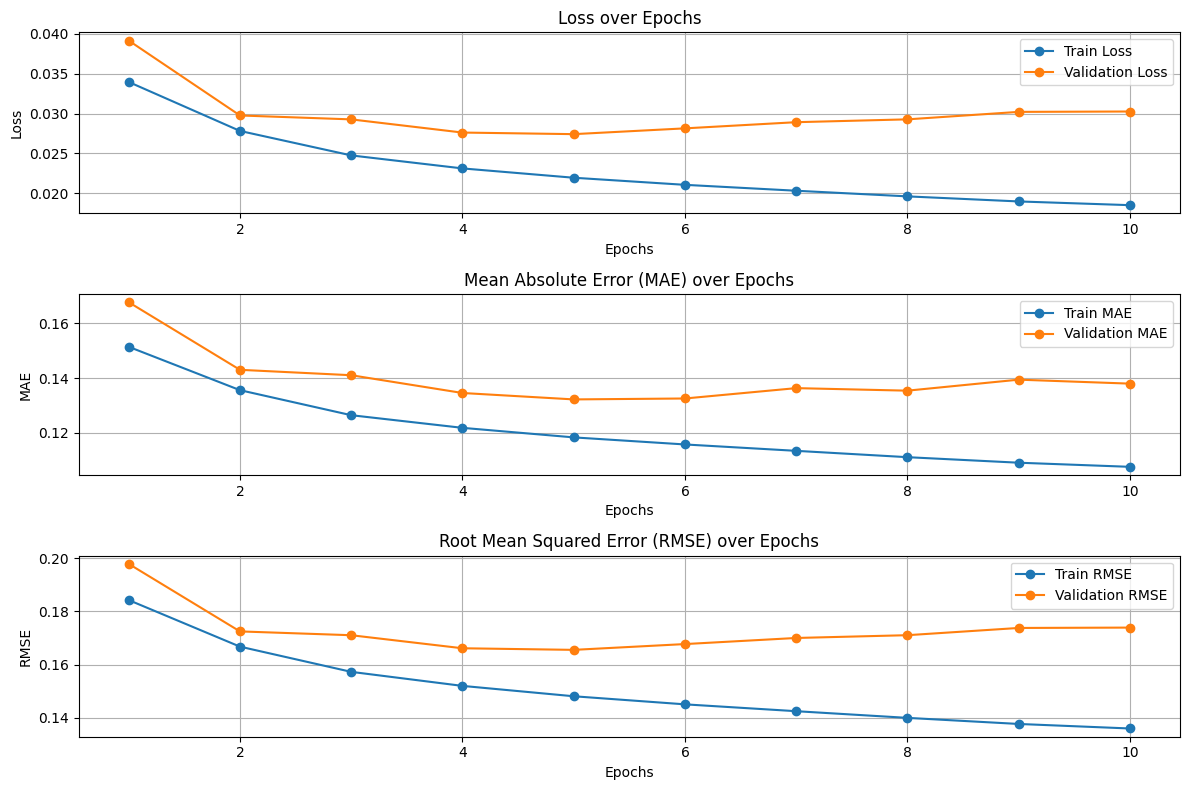

In [ ]:
plot_training_history(history_word)

#Extract features

In [ ]:
# Define function to extract features from the siamese model
def extract_features(model, search_input, title_input, batch_size=64):
    """
    Extract features using the shared LSTM outputs of the Siamese model.

    :param model: Pretrained Siamese model.
    :param search_input: Input data for the search queries.
    :param title_input: Input data for the product titles.
    :param batch_size: Batch size for prediction.
    :return: Numpy array of extracted features.
    """
    # Create a sub-model for feature extraction
    feature_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.get_layer("shared_lstm").output  # Extract shared LSTM output
    )
    # Extract features using the shared LSTM layer
    features = feature_model.predict([search_input, title_input], batch_size=batch_size)
    return features

# Extract features from train, validation, and test datasets
train_features = extract_features(siamese_model, train_search, train_title)
val_features = extract_features(siamese_model, val_search, val_title)  # For validation
test_features = extract_features(siamese_model, test_search, test_title)

# Flatten the LSTM output to feed into classical ML models
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)  # For validation
test_features = test_features.reshape(test_features.shape[0], -1)

# Prepare labels
train_labels = train_labels  # Replace 'relevance' with your target column
val_labels = val_labels  # For validation
test_labels = solution['relevance']  # Replace 'relevance' with your target column

# Print shapes to verify
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Train features shape: (59253, 64)
Validation features shape: (14814, 64)
Test features shape: (166693, 64)


## Model 1 Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(train_features, train_labels)

# Predict and evaluate
lr_train_predictions = lr_model.predict(train_features)
lr_test_predictions = lr_model.predict(test_features)
train_labels_np = train_labels.numpy()
lr_train_rmse = mean_squared_error(train_labels_np, lr_train_predictions)
lr_test_rmse = mean_squared_error(test_labels, lr_test_predictions)

print(f"Linear Regression - Train RMSE: {lr_train_rmse}, Test RMSE: {lr_test_rmse}")

Linear Regression - Train RMSE: 0.021758602932095528, Test RMSE: 2.9745967280711922


# Model 2 Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

# Predict and evaluate
rf_train_predictions = rf_model.predict(train_features)
rf_test_predictions = rf_model.predict(test_features)

train_labels_np = train_labels.numpy()

rf_train_rmse = mean_squared_error(train_labels_np, rf_train_predictions)
rf_test_rmse = mean_squared_error(test_labels, rf_test_predictions)

print(f"Random Forest - Train RMSE: {rf_train_rmse}, Test RMSE: {rf_test_rmse}")

# Compare R^2 scores
lr_r2 = r2_score(test_labels, lr_test_predictions)
rf_r2 = r2_score(test_labels, rf_test_predictions)

print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")

#D

# We chose bert

In [ ]:
# Load pre-trained BERT and tokenizer
bert_model_name = "bert-base-uncased"
bert_model = TFBertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Define input shapes
input_length = 50  # Example input length (ensure padding/truncation for this length)

# Define input layers
search_input_ids = Input(shape=(input_length,), dtype=tf.int32, name="search_input_ids")
title_input_ids = Input(shape=(input_length,), dtype=tf.int32, name="title_input_ids")

# Use BERT to extract embeddings
def extract_bert_embedding(input_ids):
    bert_output = bert_model(input_ids)
    return bert_output.last_hidden_state[:, 0, :]  # CLS token representation


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Define Lambda layers for BERT embeddings

bert_embedding1 = Lambda(
    extract_bert_embedding,
    output_shape=(bert_model.config.hidden_size,),  # Hidden size of BERT
    name="bert_embedding1"
)(search_input_ids)

bert_embedding2 = Lambda(
    extract_bert_embedding,
    output_shape=(bert_model.config.hidden_size,),  # Hidden size of BERT
    name="bert_embedding2"
)(title_input_ids)

# Compute absolute difference between embeddings
embedding_difference = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name="lambda_2")(
    [bert_embedding1, bert_embedding2]
)

# Add dense layers
dense_1 = Dense(64, activation="relu", name="dense_2")(embedding_difference)
dense_2 = Dense(32, activation="relu", name="dense_3")(dense_1)
output = Dense(1, activation="sigmoid", name="output_layer")(dense_2)

# Build the model
siamese_bert_model = Model(inputs=[search_input_ids, title_input_ids], outputs=output)

# Compile the model
siamese_bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse') ])

# Model summary
siamese_bert_model.summary()

# Tokenize and preprocess data
def preprocess_texts(texts, max_length):
    """
    Preprocess a list of texts for BERT tokenizer.
    Ensures all texts are strings and handles empty or non-string values.

    :param texts: List of input texts.
    :param max_length: Maximum sequence length for tokenizer.
    :return: Tokenized input IDs.
    """
    clean_texts = [str(text) if isinstance(text, str) else "" for text in texts]

    return tokenizer(
        clean_texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )["input_ids"]

# Example usage
train_df, val_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42
)
search_texts = preprocess_texts(train_df['search_term'], input_length)
title_texts = preprocess_texts(train_df['product_title'], input_length)
labels_train = train_df['relevance_normalized']

val_search_texts = preprocess_texts(val_df['search_term'], input_length)
val_title_texts = preprocess_texts(val_df['product_title'], input_length)
labels_val = val_df['relevance_normalized']


# Train the model (example; replace with your data)
history_bert_word=siamese_bert_model.fit(
    [search_texts, title_texts],
    labels_train,validation_data = ([val_search_texts, val_title_texts],labels_val),
    epochs=5,
    batch_size=32
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ search_input_ids          │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ title_input_ids           │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_embedding1 (Lambda)  │ (None, 768)            │              0 │ search_input_ids[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_embedding2 (Lambda)  │ (None, 768)            │              0 │ title_input_ids[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 768)            │              0 │ bert_embedding1[0][0], │
│                           │                        │                │ bert_embedding2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │         49,216 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │             33 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

1852/1852 ━━━━━━━━━━━━━━━━━━━━ 490s 244ms/step - loss: 0.0338 - mae: 0.1507 - rmse: 0.1838 - val_loss: 0.0308 - val_mae: 0.1444 - val_rmse: 0.1755


In [ ]:
predictions = siamese_bert_model.predict([test_search, test_title])
predictions = pd.DataFrame(predictions)
predictions

solution = pd.read_csv("/content/solution.csv")

predictions['id'] = solution['id']
predictions.rename(columns={0: 'relevance'}, inplace=True)
predictions

# Merge the DataFrames on 'id'
merged_df = pd.merge(predictions, solution, on='id', suffixes=('_pred', '_true'))

# Filter out rows where the true relevance is -1
filtered_df = merged_df[merged_df['relevance_true'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['relevance_pred'].values
true_relevance = filtered_df['relevance_true'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")


# Predict on the test set
test_predictions = siamese_bert_model.predict([test_search, test_title])

# Rescale predictions back to original relevance score range
test_predictions = test_predictions * train['relevance'].max()

print(test_predictions)



test_predictions = pd.DataFrame(test_predictions)

solution['prediction'] = test_predictions[0]

# Filter out rows where the true relevance is -1
filtered_df = solution[solution['relevance'] != -1]

# Extract the predicted and true relevance
predicted_relevance = filtered_df['prediction'].values
true_relevance = filtered_df['relevance'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_relevance, predicted_relevance))

print(f"Root Mean Squared Error (RMSE): {rmse}")

5210/5210 ━━━━━━━━━━━━━━━━━━━━ 845s 160ms/step
Root Mean Squared Error (RMSE): 1.7541038122532517
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 816s 157ms/step
[[2.232119 ]
 [2.1898065]
 [2.0759878]
 ...
 [2.139224 ]
 [2.0875278]
 [2.1675067]]
Root Mean Squared Error (RMSE): 0.5927240575356181


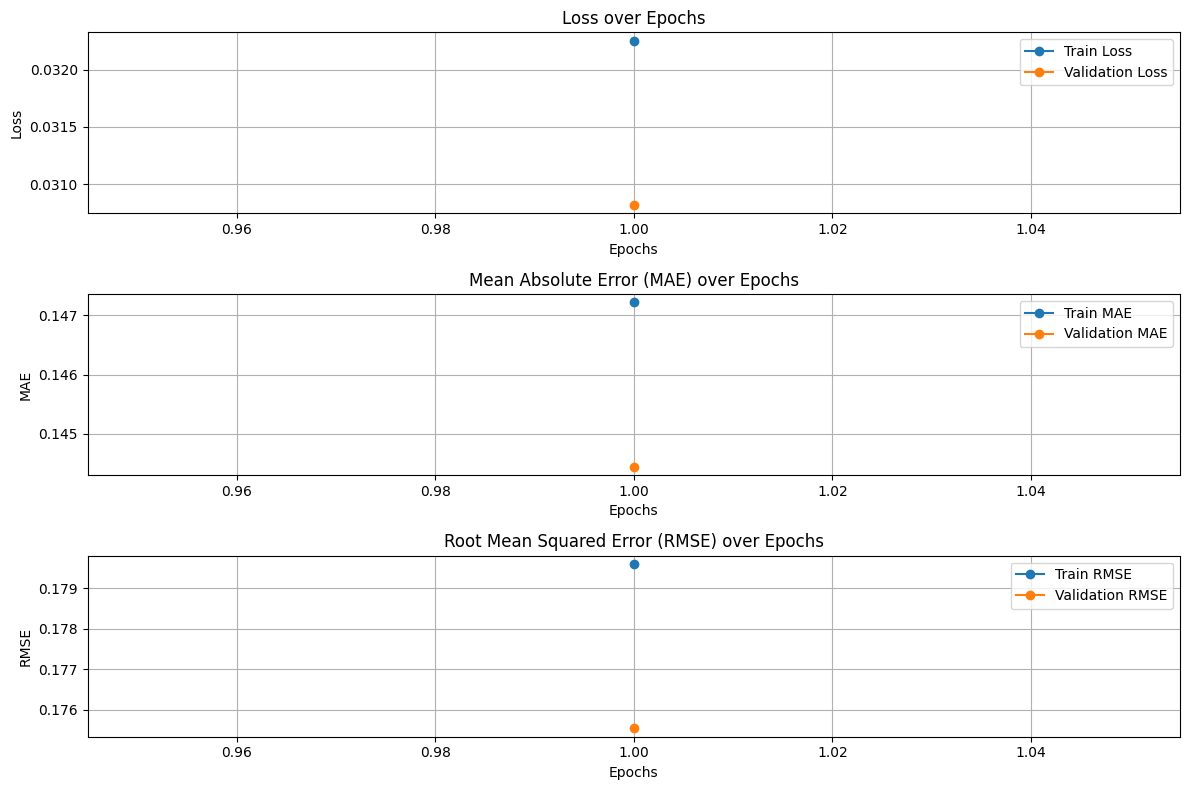

In [ ]:
plot_training_history(history_bert_word)
